# AML Group 21 - Species
### Gabin's notebook

- The first few cells are dedicated to the provided code for simple visualisation and data loading.

### Useful links
- pyinaturalist documentation : https://pyinaturalist.readthedocs.io/en/stable/index.html
- geopy documentation : https://geopy.readthedocs.io/en/stable/
- Tutorial to geopy (esp. reverse geocoding) : https://pythonsimplified.com/geocoding-in-python-using-geopy/

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# loading training data    
data = np.load('species_train.npz')
train_locs = data['train_locs']  # 2D array, rows are number of datapoints and 
                                 # columns are "latitude" and "longitude"
train_ids = data['train_ids']    # 1D array, entries are the ID of the species 
                                 # that is present at the corresponding location in train_locs
species = data['taxon_ids']      # list of species IDe. Note these do not necessarily start at 0 (or 1)
species_names = dict(zip(data['taxon_ids'], data['taxon_names']))  # latin names of species 

# loading test data 
data_test = np.load('species_test.npz', allow_pickle=True)
test_locs = data_test['test_locs']    # 2D array, rows are number of datapoints 
                                      # and columns are "latitude" and "longitude"
# data_test['test_pos_inds'] is a list of lists, where each list corresponds to 
# the indices in test_locs where a given species is present, it can be assumed 
# that they are not present in the other locations (format: dictionary with taxon id as key to the list of locs)
test_pos_inds = dict(zip(data_test['taxon_ids'], data_test['test_pos_inds']))    



## Data visualisation

Train Stats:
Number of species in train set:            500
Number of train locations:                 272037
Average number of locations per species:   544.074
Minimum number of locations for a species: 50
Maximum number of locations for a species: 2000

Displaying random species:
22973 - Leptodactylus fuscus


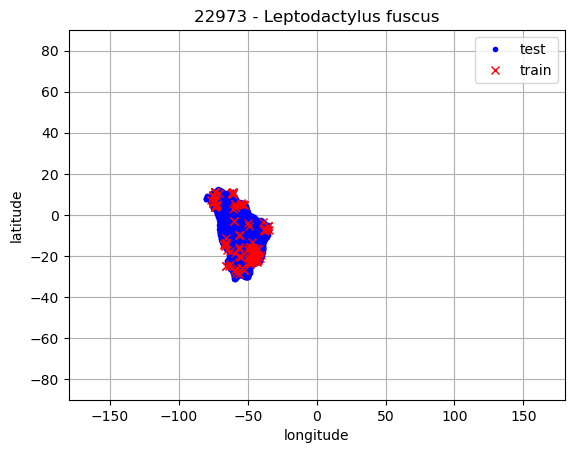

In [27]:
# data stats
print('Train Stats:')
print('Number of species in train set:           ', len(species))
print('Number of train locations:                ', train_locs.shape[0])
_, species_counts = np.unique(train_ids, return_counts=True)
print('Average number of locations per species:  ', species_counts.mean())
print('Minimum number of locations for a species:', species_counts.min())
print('Maximum number of locations for a species:', species_counts.max())


# plot train and test data for a random species
plt.close('all')
plt.figure(0)

sp = np.random.choice(species)
print('\nDisplaying random species:')
print(str(sp) + ' - ' + species_names[sp]) 

# get test locations and plot
# test_inds_pos is the locations where the selected species is present
# test_inds_neg is the locations where the selected species is not present
test_inds_pos = test_pos_inds[sp]  
test_inds_neg = np.setdiff1d(np.arange(test_locs.shape[0]), test_pos_inds[sp])
plt.plot(test_locs[test_inds_pos, 1], test_locs[test_inds_pos, 0], 'b.', label='test')

# get train locations and plot
train_inds_pos = np.where(train_ids == sp)[0]
plt.plot(train_locs[train_inds_pos, 1], train_locs[train_inds_pos, 0], 'rx', label='train')

plt.title(str(sp) + ' - ' + species_names[sp])
plt.grid(True)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.legend()
plt.show()



In [30]:
data_test

NpzFile 'species_test.npz' with keys: test_locs, test_pos_inds, taxon_ids, taxon_names, allow_pickle